# Traffic sign classification with CNNs

In this notebook, we'll train a convolutional neural network (CNN, ConvNet) to classify images of traffic signs from [The German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) using TensorFlow 2.0 / Keras. This notebook is largely based on the blog post [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) by François Chollet.

**Note that using a GPU with this notebook is highly recommended.**

First, the needed imports.

In [1]:
%matplotlib inline

import os, datetime
import random
import pathlib

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, InputLayer, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications, optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

from IPython.display import SVG

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

print('Using Tensorflow version: {}, and Keras version: {}.'.format(tf.__version__, tf.keras.__version__))

Using Tensorflow version: 2.0.0-rc0, and Keras version: 2.2.4-tf.


If we are using TensorFlow as the backend, we can use TensorBoard to visualize our progress during training.

## Data

The training dataset consists of 5535 images of traffic signs of varying size. There are 43 different types of traffic signs:

![title](imgs/gtsrb-montage.png)

The validation and test sets consist of 999 and 12630 images, respectively.

### Downloading the data

In [2]:
datapath = "/media/data/gtsrb/train-5535/"
nimages = dict()
(nimages['train'], nimages['validation'], nimages['test']) = (5535, 999, 12630)

### Parameters

In [3]:
INPUT_IMAGE_SIZE = [75, 75, 3]
BATCH_SIZE = 50
NUM_CLASSES = 43

### Image paths and labels

In [4]:
def get_paths(dataset):
    data_root = pathlib.Path(datapath+dataset)
    image_paths = list(data_root.glob('*/*'))
    image_paths = [str(path) for path in image_paths]
    image_count = len(image_paths)
    assert image_count == nimages[dataset], "Found {} images, expected {}".format(image_count, nimages[dataset])
    return image_paths

image_paths = dict()
image_paths['train'] = get_paths('train')
image_paths['validation'] = get_paths('validation')
image_paths['test'] = get_paths('test')

In [5]:
label_names = sorted(item.name for item in pathlib.Path(datapath+'train').glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index,name in enumerate(label_names))

In [6]:
def get_labels(dataset):
    return [label_to_index[pathlib.Path(path).parent.name]
            for path in image_paths[dataset]]
    
image_labels = dict()
image_labels['train'] = get_labels('train')
image_labels['validation'] = get_labels('validation')
image_labels['test'] = get_labels('test')

### Data augmentation

We need to resize all training and validation images to a fixed size. 

Then, to make the most of our limited number of training examples, we'll apply random transformations (crop and horizontal flip) to them each time we are looping over them. This way, we "augment" our training dataset to contain more data. There are various transformations readily available in TensorFlow, see [tf.image](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/image) for more information.

In [7]:
#from tensorflow.contrib.image import matrices_to_flat_transforms, transform

def _load_image(path, label):
    image = Image.open(path.numpy())
    return np.array(image), label # tf.one_hot(label, NUM_CLASSES)

def transform_image(image, forward_transform):
    t = matrices_to_flat_transforms(tf.linalg.inv(forward_transform))
    return transform(image, t, interpolation="BILINEAR", name=None)

def load_image(path, label):
    return tf.py_function(_load_image, (path, label), (tf.float32, tf.int32))

def preprocess_image(image, augment):
    image.set_shape([None, None, None])
    if augment:
        image = tf.image.resize(image, [80, 80])
        image = tf.image.random_crop(image, INPUT_IMAGE_SIZE)
        if random.random() < 0.5:
            image = tf.image.flip_left_right(image)
        #image = transform_image(image, [[1.0, 0.2, 0], [0, 1.0, 0], [0, 0, 1.0]])
    else:
        image = tf.image.resize(image, INPUT_IMAGE_SIZE[:2])
    image /= 255.0  # normalize to [0,1] range
    image.set_shape(INPUT_IMAGE_SIZE)
    return image

def process_and_augment_image(image, label):
    return preprocess_image(image, True), label

def process_and_not_augment_image(image, label):
    return preprocess_image(image, False), label

### TF Datasets

Let's now define our [TF `Dataset`s](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#class_dataset) for training, validation, and test data. We augment only the training data.

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths['train'], image_labels['train']))
train_dataset = train_dataset.map(load_image)
train_dataset = train_dataset.map(process_and_augment_image, num_parallel_calls=10)
train_dataset = train_dataset.shuffle(2000).batch(BATCH_SIZE, drop_remainder=True)

validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths['validation'], image_labels['validation']))
validation_dataset = validation_dataset.map(load_image)
validation_dataset = validation_dataset.map(process_and_not_augment_image, num_parallel_calls=10)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((image_paths['test'], image_labels['test']))
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.map(process_and_not_augment_image, num_parallel_calls=10)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)

Let's see a couple of augmented training images and not augmented validation images.

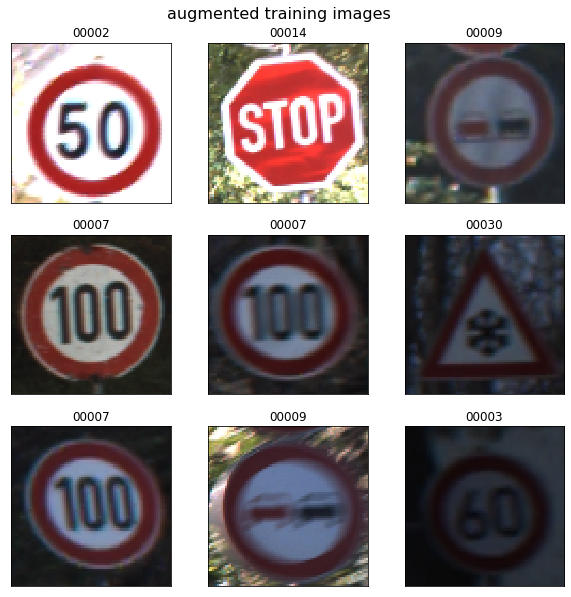

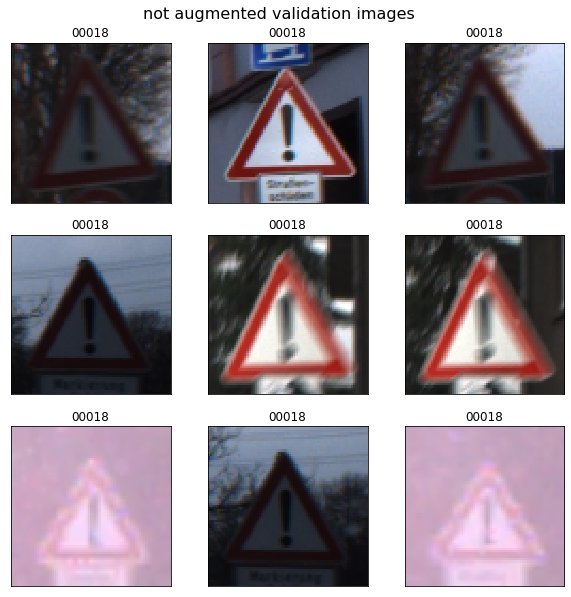

In [9]:
plt.figure(figsize=(10,10))
for batch, labels in train_dataset.take(1):
    for i in range(9):    
        plt.subplot(3,3,i+1)
        plt.imshow(batch[i,:,:,:])
        plt.title(label_names[labels[i]])
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.suptitle('augmented training images', fontsize=16, y=0.93)
    
plt.figure(figsize=(10,10))
for batch, labels in validation_dataset.take(1):
    for i in range(9):    
        plt.subplot(3,3,i+1)
        plt.imshow(batch[i,:,:,:])
        plt.title(label_names[labels[i]])
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.suptitle('not augmented validation images', fontsize=16, y=0.93)

## Option 1: Train a small CNN from scratch

Similarly as with MNIST digits, we can start from scratch and train a CNN for the classification task.

### Initialization

In [10]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=INPUT_IMAGE_SIZE, 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

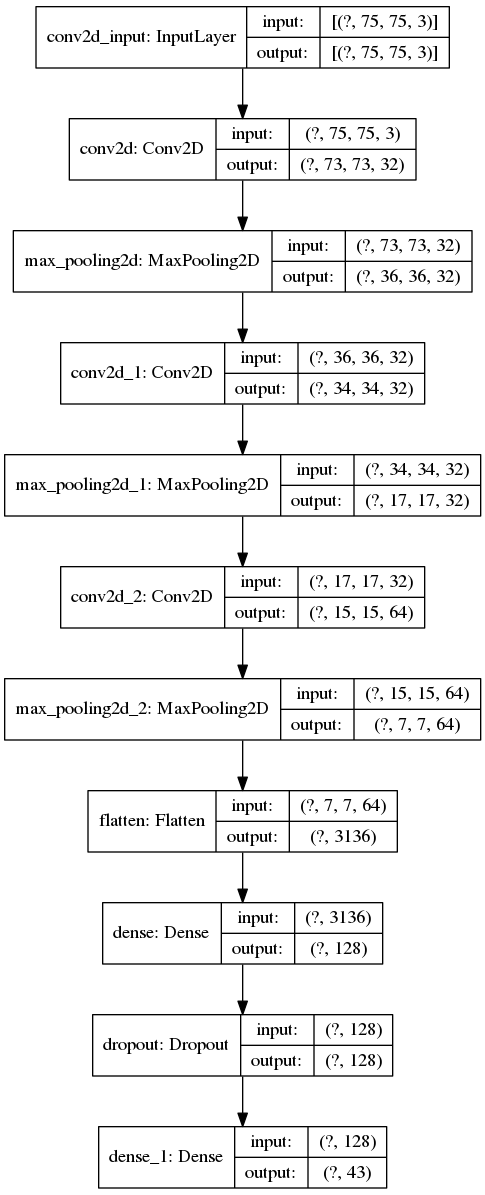

In [11]:
plot_model(model, show_shapes=True)

### Learning

We'll use TensorBoard to visualize our progress during training.

In [12]:
logdir = os.path.join(os.getcwd(), "logs",
                      "gtsrb-small-cnn-"+datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
print('TensorBoard log directory:', logdir)
os.makedirs(logdir)
callbacks = [TensorBoard(log_dir=logdir)]

TensorBoard log directory: /media/data/code/machine-learning-scripts/notebooks/logs/gtsrb-small-cnn-2019-09-04_14-13-02


In [13]:
%%time

epochs = 20 

history = model.fit(train_dataset, epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks, verbose=2)

model.save("gtsrb-small-cnn.h5")

Epoch 1/20


ValueError: as_list() is not defined on an unknown TensorShape.

In [14]:
#Traffic signs results:
#trained from scratch (gtsrb-small-cnn.h5), test set acc: 84.20%
#pretrained (gtsrb-vgg16-reuse.h5): test set acc: 59.89%
#pretrained and finetuned (gtsrb-vgg16-finetune.h5): test set acc: 69.16%

In [15]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'], label='training')
plt.plot(history.epoch,history.history['val_accuracy'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

NameError: name 'history' is not defined

<Figure size 360x216 with 0 Axes>

### Inference

In [ ]:
%%time
scores = model.evaluate(test_dataset, verbose=2)
print("Test set %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Option 2: Reuse a pre-trained CNN

Another option is to reuse a pretrained network.  Here we'll use the [VGG16](https://keras.io/applications/#vgg16) network architecture with weights learned using Imagenet.  We remove the top layers and freeze the pre-trained weights. 

### Initialization

In [ ]:
model = Sequential()

model.add(InputLayer(input_shape=input_image_size+(3,)))  # possibly needed due to a bug in Keras

pt_model = applications.VGG16(weights='imagenet', include_top=False,
                              input_shape=input_image_size+(3,))
# pt_model = applications.MobileNet(weights='imagenet', include_top=False,
#                                   input_shape=input_image_size+(3,))

pt_name = pt_model.name
print('Using {} pre-trained model'.format(pt_name))

for layer in pt_model.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable = False


print(model.summary())

We then stack our own, randomly initialized layers on top of the VGG16 network.

In [ ]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(43, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

### Learning 1: New layers

In [ ]:
%%time

epochs = 20 

history = model.fit_generator(train_generator,
                              steps_per_epoch=nimages_train // batch_size,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=nimages_validation // batch_size,
                              verbose=2, callbacks=callbacks)

model.save("gtsrb-" + pt_name + "-reuse.h5")

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'], label='training')
plt.plot(history.epoch,history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

### Learning 2: Fine-tuning

Once the top layers have learned some reasonable weights, we can continue training by unfreezing the last convolution block of VGG16 (`block5`) so that it may adapt to our data. The learning rate should be smaller than usual. 

In [ ]:
for layer in model.layers[15:]:   # VGG16
# for layer in model.layers[75:]:    # MobileNet                                                                                                
    layer.trainable = True
    print(layer.name, "now trainable")
    
model.compile(loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['accuracy'])

#print(model.summary())

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

Note that before continuing the training, we create a separate TensorBoard log directory:

In [ ]:
%%time

epochs = 20 

if K.backend() == "tensorflow":
    logdir_ft = logdir + "-ft"
    os.makedirs(logdir_ft)
    callbacks_ft = [TensorBoard(log_dir=logdir_ft)]
else:
    callbacks_ft = None

history = model.fit_generator(train_generator,
                              steps_per_epoch=nimages_train // batch_size,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=nimages_validation // batch_size,
                              verbose=2, callbacks=callbacks_ft)

model.save("gtsrb-" + pt_name + "-finetune.h5")

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'], label='training')
plt.plot(history.epoch,history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

### Inference

In [ ]:
%%time
scores = model.evaluate_generator(test_generator,
                                  steps=nimages_test // batch_size)
print("Test set %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))